# Permutation Assembly Flow-Shop Scheduling Problem

This is a variant of the Flow-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine and there are assembly operations with arbitrary machine precedences.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & h_{i,k} + \sum_{j \in J} p_{j,i} x_{j,k} \leq h_{j,k}
         & \forall ~ (i,j) \in E; k \in K\\
     & h_{m,k} + \sum_{j \in J} p_{j,m} x_{j,k} \leq h_{m,k+1}
         & \forall ~ m \in M; k \in K \setminus \{|K|\}\\
     & \sum_{j \in J} x_{j,k} = 1
         & \forall ~ k \in K\\
     & \sum_{k \in K} x_{j,k} = 1
         & \forall ~ j \in J\\
     & h_{m,|K|} + \sum_{j \in J} p_{j,m} x_{j,|K|} \leq C_{\text{max}}
         & \forall ~ m \in M\\
     & h_{m,k} \geq 0 & \forall ~ m \in M; k \in K\\
     & x_{j,k} \in \{0, 1\} & \forall ~ j \in J; k \in K\\
 \end{align}
 $$

Where $E$ represents the set of directed edges $(i,j)$ indicating that machine $i$ must precede machine $j$ in the processing sequence.

You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [1]:
import pyomo.environ as pyo

from bnbprob.pafssp import CallbackBnB, PermFlowShop, plot_gantt
from bnbprob.pafssp.instances import (
    random_dpm,
    random_parallel_semilines,
)
from bnbprob.pafssp.mip.positional import positional_model
from bnbpy import configure_logfile


In [2]:
configure_logfile("pafssp.log", mode="w")

## Parallel Semi-lines

In [3]:
instance = random_parallel_semilines(20, (3, 3), seed=17)
print(instance.edges)

[(0, 1), (2, 3), (3, 4), (1, 4)]


In [4]:
# Literature mini-example
p = [
    [10, 18, 14, 16, 22],
    [6, 37, 18, 9, 25],
    [5, 4, 21, 8, 19],
]

instance.p = p

In [5]:
problem = PermFlowShop.from_p(instance.p, edges=instance.edges)
bnb = CallbackBnB(rtol=0.0001, save_tree=False)

In [6]:
sol = bnb.solve(problem, maxiter=10_000_000)
print(sol)

Status: OPTIMAL | Cost: 95.0 | LB: 95.0


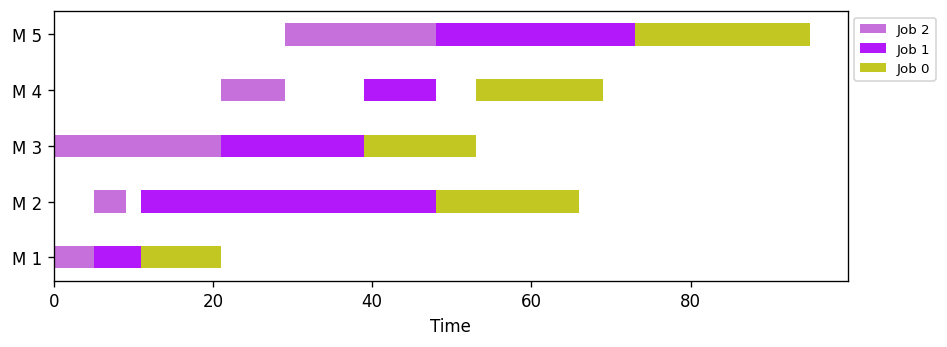

In [7]:
plot_gantt(sol.problem.sequence, dpi=120, seed=42, figsize=[8, 3])

## DPm -> Fm Layout

In [35]:
for m_set in [(2, 5), (5, 5), (2, 6), (5, 6)]:
    for i in range(10):
        instance = random_parallel_semilines(12, m_set, seed=i)
        problem = PermFlowShop.from_p(
            instance.p, edges=instance.edges, constructive='neh'
        )
        bnb = CallbackBnB(rtol=0.0001, save_tree=False)

        sol = bnb.solve(problem, maxiter=1_000_000)

        print(f"Machines: {m_set} | {i}, Makespan: {sol.cost}")

Machines: (2, 5) | 0, Makespan: 947.0
Machines: (2, 5) | 1, Makespan: 824.0
Machines: (2, 5) | 2, Makespan: 916.0
Machines: (2, 5) | 3, Makespan: 878.0
Machines: (2, 5) | 4, Makespan: 727.0
Machines: (2, 5) | 5, Makespan: 726.0
Machines: (2, 5) | 6, Makespan: 838.0
Machines: (2, 5) | 7, Makespan: 787.0
Machines: (2, 5) | 8, Makespan: 827.0
Machines: (2, 5) | 9, Makespan: 780.0
Machines: (5, 5) | 0, Makespan: 859.0
Machines: (5, 5) | 1, Makespan: 920.0
Machines: (5, 5) | 2, Makespan: 982.0
Machines: (5, 5) | 3, Makespan: 933.0
Machines: (5, 5) | 4, Makespan: 825.0
Machines: (5, 5) | 5, Makespan: 760.0
Machines: (5, 5) | 6, Makespan: 974.0
Machines: (5, 5) | 7, Makespan: 875.0
Machines: (5, 5) | 8, Makespan: 844.0
Machines: (5, 5) | 9, Makespan: 814.0
Machines: (2, 6) | 0, Makespan: 900.0
Machines: (2, 6) | 1, Makespan: 951.0
Machines: (2, 6) | 2, Makespan: 974.0
Machines: (2, 6) | 3, Makespan: 1038.0
Machines: (2, 6) | 4, Makespan: 912.0
Machines: (2, 6) | 5, Makespan: 878.0
Machines: (

In [34]:
for m_set in [(2, 5), (5, 5), (2, 6), (5, 6)]:
    for i in range(10):
        instance = random_parallel_semilines(12, m_set, seed=i)
        problem = PermFlowShop.from_p(
            instance.p, edges=instance.edges, constructive='neh'
        )
        bnb = CallbackBnB(rtol=0.0001, save_tree=False)

        sol = bnb.solve(problem, maxiter=1_000_000)

        mip = positional_model(instance.p, edges=instance.edges)
        solver = pyo.SolverFactory("appsi_highs")
        solver.solve(mip, tee=True)

        diff = (pyo.value(mip.obj) - sol.cost) ** 2
        print(f"Machines: {m_set} | {i}, Makespan: {sol.cost}; Diff: {diff}")

Machines: (2, 5) | 0, Makespan: 947.0; Diff: 4.9682535541466225e-23
Machines: (2, 5) | 1, Makespan: 824.0; Diff: 4.652890945610781e-25
Machines: (2, 5) | 2, Makespan: 916.0; Diff: 2.0679515313825692e-25
Machines: (2, 5) | 3, Makespan: 878.0; Diff: 4.652890945610781e-25
Machines: (2, 5) | 4, Makespan: 727.0; Diff: 0.0
Machines: (2, 5) | 5, Makespan: 726.0; Diff: 0.0
Machines: (2, 5) | 6, Makespan: 838.0; Diff: 1.4591466005435408e-21
Machines: (2, 5) | 7, Makespan: 787.0; Diff: 1.8302663522442851e-22
Machines: (2, 5) | 8, Makespan: 827.0; Diff: 0.0
Machines: (2, 5) | 9, Makespan: 780.0; Diff: 0.0
Machines: (5, 5) | 0, Makespan: 859.0; Diff: 1.258141711693155e-21
Machines: (5, 5) | 1, Makespan: 920.0; Diff: 0.0
Machines: (5, 5) | 2, Makespan: 982.0; Diff: 9.648234664818515e-21
Machines: (5, 5) | 3, Makespan: 933.0; Diff: 1.2924697071141057e-24
Machines: (5, 5) | 4, Makespan: 825.0; Diff: 2.476491761595941e-16
Machines: (5, 5) | 5, Makespan: 760.0; Diff: 0.0
Machines: (5, 5) | 6, Makespan:

In [28]:
instance = random_dpm(13, (6, 6), seed=13)
print(instance.edges)

[(0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11)]


In [29]:
problem = PermFlowShop.from_p(instance.p, edges=instance.edges)
bnb = CallbackBnB()

In [30]:
sol = bnb.solve(problem, maxiter=10_000_000)
print(sol)

Status: OPTIMAL | Cost: 1183.0 | LB: 1183.0


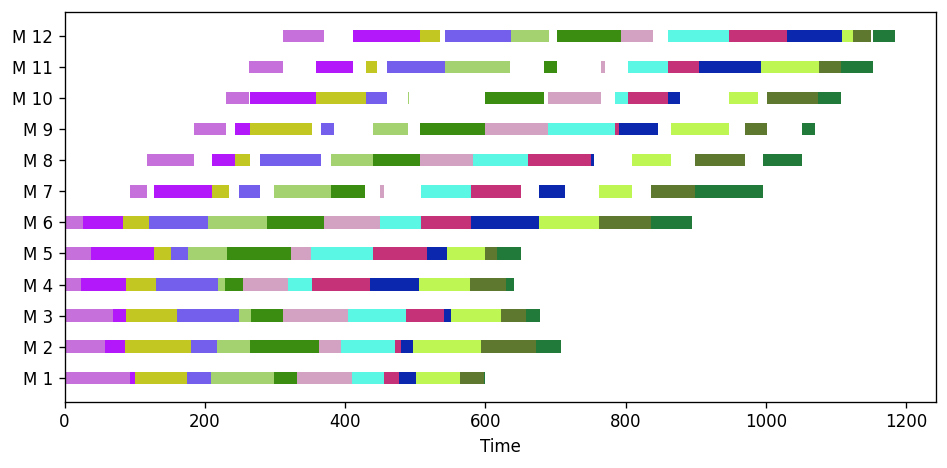

In [31]:
sol.problem.compute_starts()
plot_gantt(sol.problem.sequence, dpi=120, seed=42, figsize=[8, 4])

## MIP Model

In [32]:
mip = positional_model(instance.p, edges=instance.edges)
solver = pyo.SolverFactory("appsi_highs")
solver.solve(mip, tee=True)

{'Problem': [{'Lower bound': 1182.9132707006813, 'Upper bound': 1183.0, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In this implmentation lower bounds are computed by
the max of a single machine and
a two machine relaxations.

The bounds for single and two-machine problems are described
by Potts (1980), also implemented by Ladhari & Haouari (2005),
therein described as 'LB1' and 'LB5'.

If the attribute `constructive` is 'neh', the heuristic
of Nawaz et al. (1983) is adopted, otherwise
the strategy by Palmer (1965).


## References

Ladhari, T., & Haouari, M. (2005). A computational study of
the permutation flow shop problem based on a tight lower bound.
Computers & Operations Research, 32(7), 1831-1847.

Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983).
A heuristic algorithm for the m-machine,
n-job flow-shop sequencing problem.
Omega, 11(1), 91-95.

Potts, C. N. (1980). An adaptive branching rule for the permutation
flow-shop problem. European Journal of Operational Research, 5(1), 19-25.

Palmer, D. S. (1965). Sequencing jobs through a multi-stage process
in the minimum total time—a quick method of obtaining a near optimum.
Journal of the Operational Research Society, 16(1), 101-107

## Bonus - MILP Model

This is the usual Position-based MILP model as an alternative to compare performance.


```python
import pyomo.environ as pyo

from bnbprob.pafssp.mip import positional_model

model = positional_model(p)


# HiGHS
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.1
solver.options["time_limit"] = 120
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)
```